# Intro - Fruit and Vegetable Image Recognition

Original dataset [found here](https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition).

(Thank you Timur for your [awesome spreadsheet!](https://docs.google.com/spreadsheets/d/1xsPRZTY8TetcZhvtqAZQ8CLj-uIRakfFa8zQ9wSBOWo/edit#gid=0))

The goal of this project is to solve an image classification problem dealing with fruits and vegetables.

This dataset contains images of the following food items:

* Fruits: banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango.
* Vegetables: cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant.

This dataset contains three folders:

* train (100 images each)
* test (10 images each)
* validation (10 images each)

Each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present.

# Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import dask.bag as db
import dask.diagnostics as dd

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

import tensorflow.keras.applications.xception as xc
import tensorflow.keras.applications.mobilenet_v2 as mn
import tensorflow.keras.applications.nasnet as nas

import keras_tuner as kt

# Exploratory Data Analysis

Since we're not dealing with tabular data, the Exploratory Data Analysis we can do is slightly different that what we've seen so far in the ML Zoomcamp course. We cannot look for null values nor calculate metrics such as correlation, risk ratio or mutual information. However, we can explore our class distribution and the nature of our images.

## Dataframe creation

We create a series of dataframes to make it easier to handle file paths.

In [2]:
# Create a list with the filepaths for training and testing
train_dir = Path('./data/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

val_dir = Path('./data/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

test_dir = Path('./data/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [3]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
        Source: https://www.kaggle.com/databeru/fruit-and-vegetable-classification/
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)
full_train_df = pd.concat([train_df, val_df])

## Basic information about our train dataset

Let's take a look at our available classes and number of images.

In [5]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3193

Number of different labels: 36

Labels: ['pomegranate' 'raddish' 'corn' 'cucumber' 'kiwi' 'chilli pepper' 'peas'
 'tomato' 'cauliflower' 'sweetcorn' 'lemon' 'bell pepper' 'jalepeno'
 'cabbage' 'orange' 'grapes' 'pear' 'banana' 'pineapple' 'mango' 'lettuce'
 'paprika' 'spinach' 'potato' 'ginger' 'sweetpotato' 'eggplant' 'capsicum'
 'turnip' 'onion' 'watermelon' 'garlic' 'apple' 'carrot' 'soy beans'
 'beetroot']


In [6]:
train_df

,Filepath,Label
0,data/train/pomegranate/Image_11.jpg,pomegranate
1,data/train/raddish/Image_96.jpg,raddish
2,data/train/corn/Image_92.jpg,corn
3,data/train/cucumber/Image_45.jpg,cucumber
4,data/train/kiwi/Image_13.jpg,kiwi
...,...,...
3188,data/train/paprika/Image_9.jpg,paprika
3189,data/train/lemon/Image_74.jpg,lemon
3190,data/train/watermelon/Image_62.jpg,watermelon
3191,data/train/onion/Image_99.jpg,onion


In [6]:
train_df['Label'].describe()

count            3193
unique             36
top       sweetpotato
freq               97
Name: Label, dtype: object

## Class distribution

Next, we take a look at the amount of images per class to check for any imbalances or biases.

In [7]:
plot_info = train_df['Label'].value_counts()

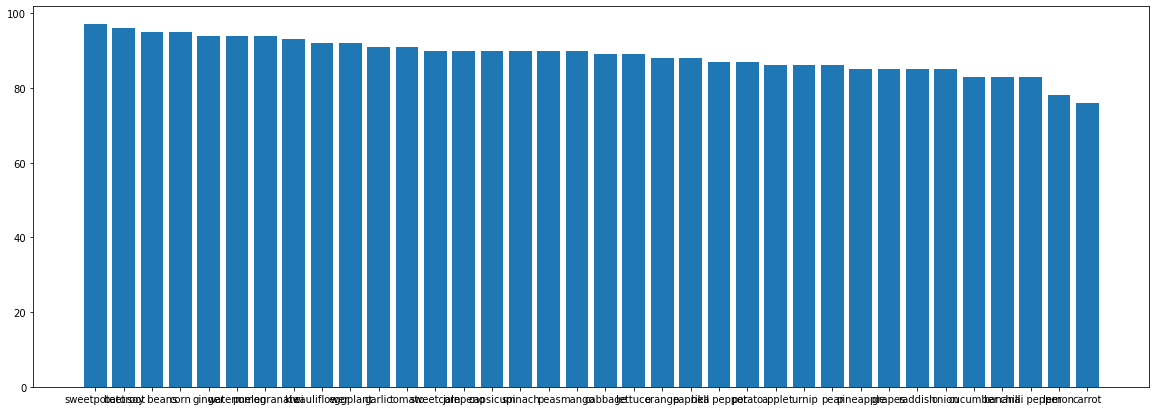

In [8]:
plt.figure(figsize=(20,7))
plt.bar(plot_info.axes[0].tolist(), plot_info.values.tolist())
plt.show()

In [9]:
plot_info.describe()

count    36.000000
mean     88.694444
std       4.791775
min      76.000000
25%      85.750000
50%      89.500000
75%      92.000000
max      97.000000
Name: Label, dtype: float64

In [10]:
plot_info.mode()

0    90
dtype: int64

We find that some classes are more represented than others, but the standard deviation is pretty small. However, given that we do not have a large amount of images, training the model might prove challenging.

## Image visualization

We take a look at some sampled images. Manually revising every image can be very time consuming, but we can take a quick look at some images to check things such as how centered the objects are in the image, background details, etc.

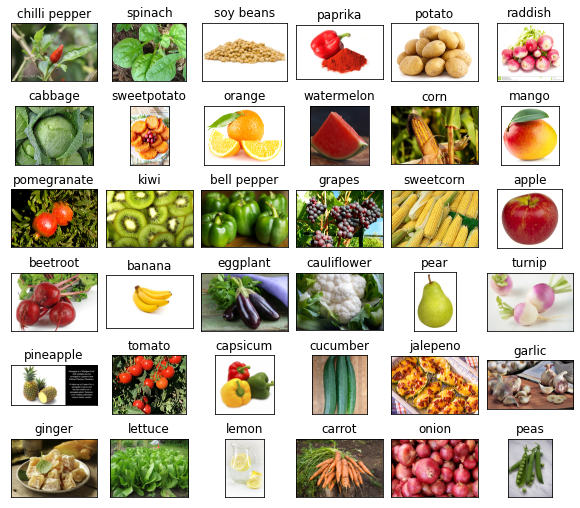

In [11]:
""" Source: https://www.kaggle.com/databeru/fruit-and-vegetable-classification/
"""

# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

The output of this block may be different between runs. However, you should be able to see samples which may be representative of their respective classes as well as other samples which may be of lesser quality. This may make training more challenging.

## Image size

Let's finally take a look at the sizes of the images we're dealing with.

In [12]:
labels = train_df.Label.unique()

In [13]:
def get_label_directory(label):
    path = 'data/train/'
    return f'{path}{label}/'

paths = []
for l in labels:
    paths.append(get_label_directory(l))

In [14]:
labels_dict = dict(zip(labels, paths))

In [15]:
def get_dims(file):
    ''' Returns dimensions for an RGB image
    '''
    im = Image.open(file)
    arr = np.array(im)
    # png array shape has only 2 elements instead of jpg's 3 elements
    if len(arr.shape) == 2:
        h,w = arr.shape
    else:
        h,w,d = arr.shape
    return h,w

[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  1.7s
[########################################] | 100

/home/ziri/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.3s
[########################################] | 100

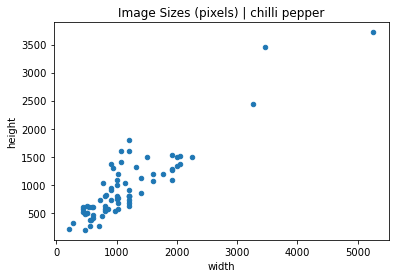

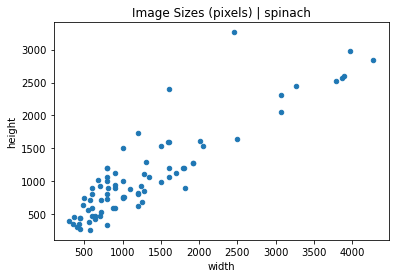

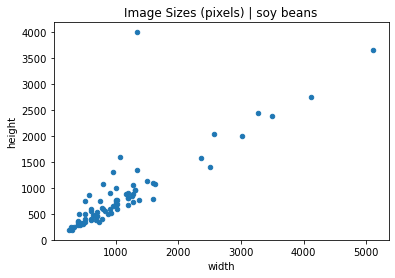

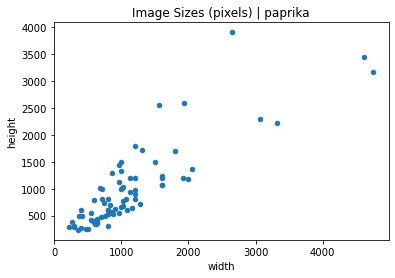

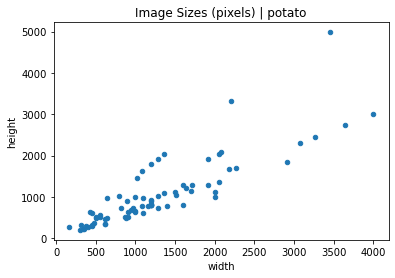

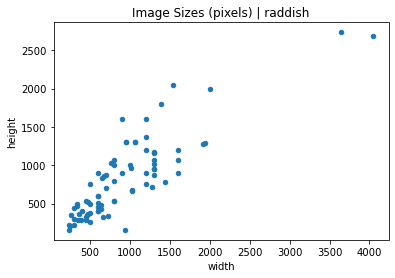

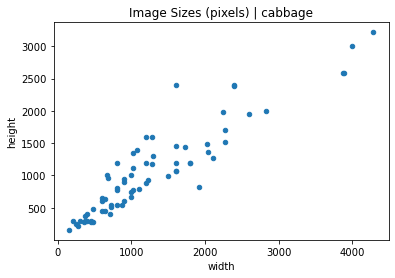

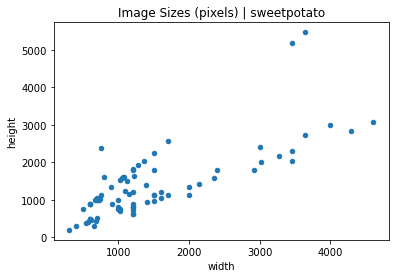

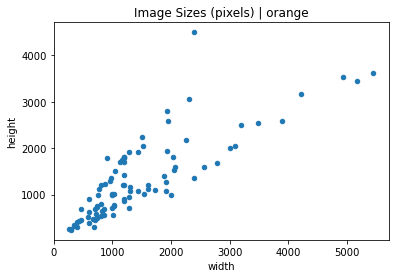

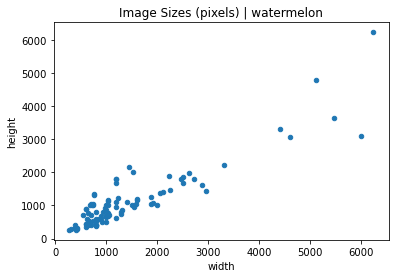

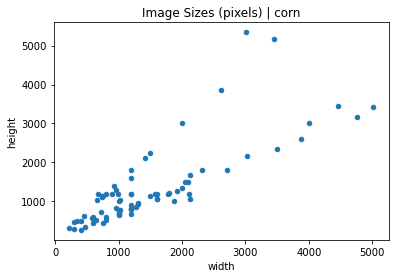

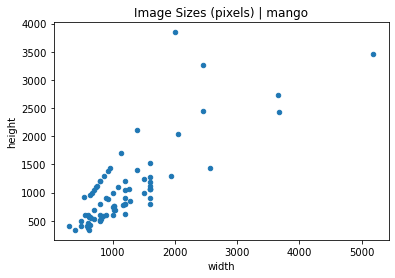

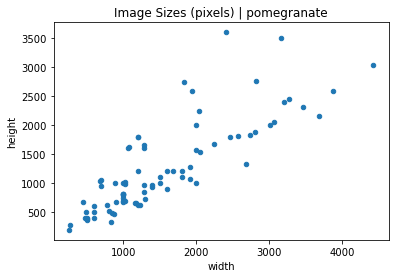

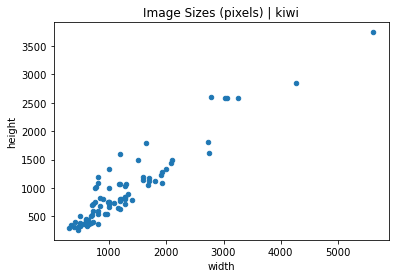

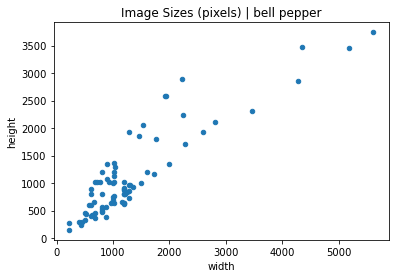

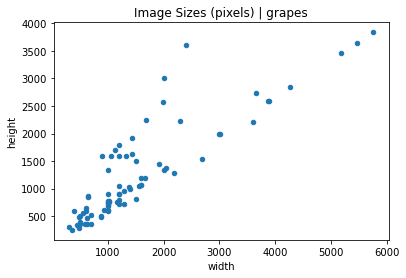

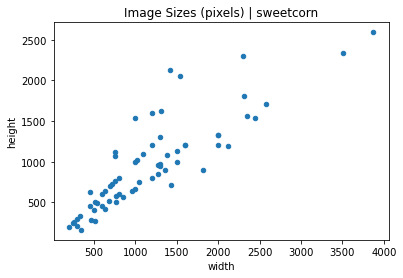

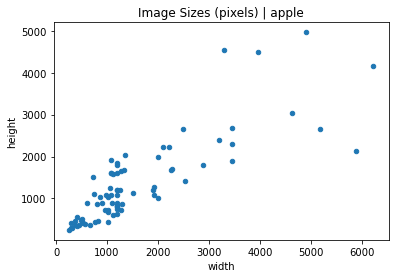

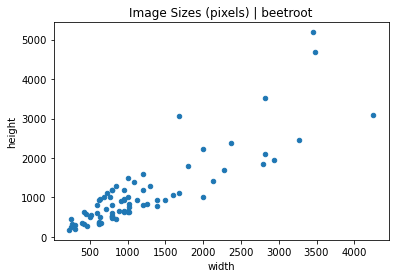

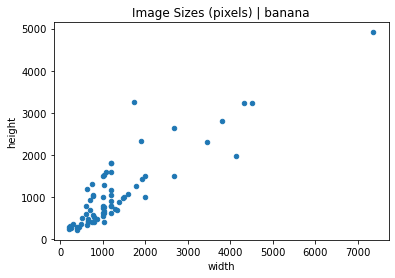

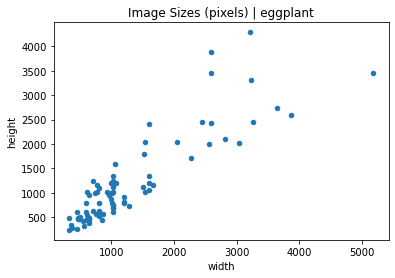

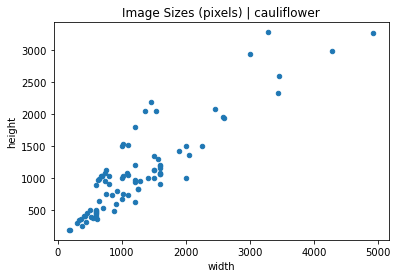

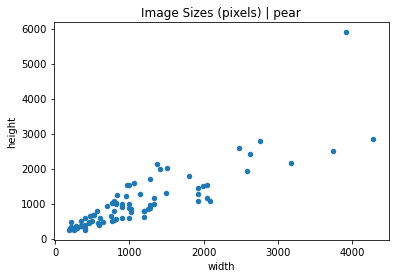

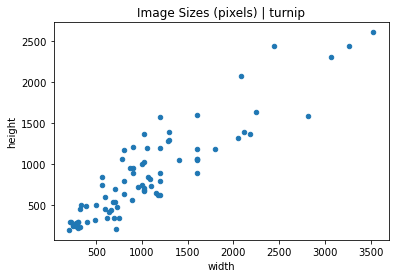

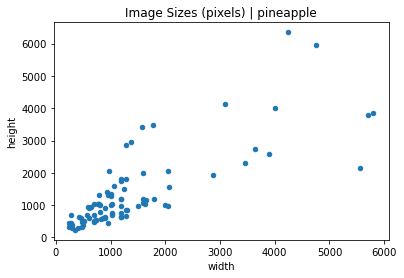

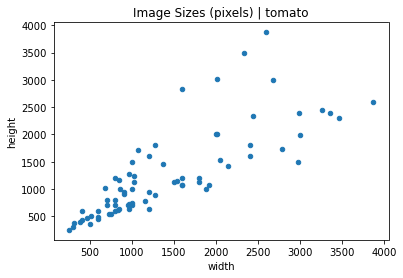

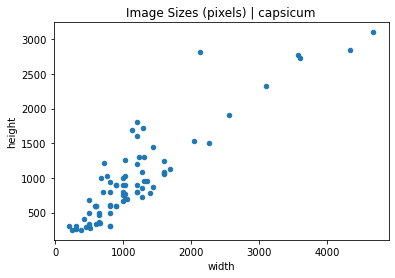

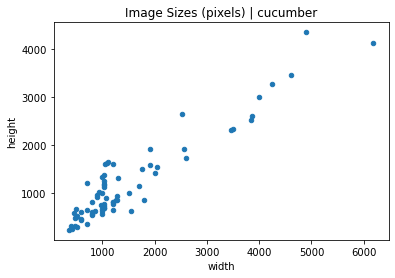

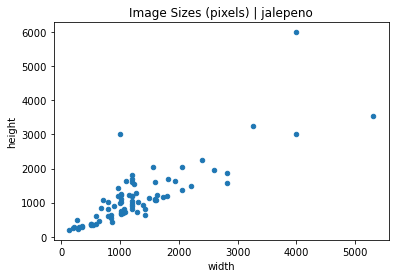

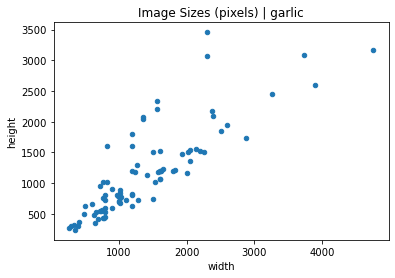

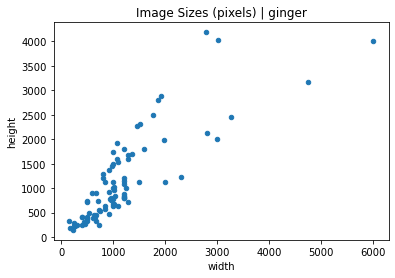

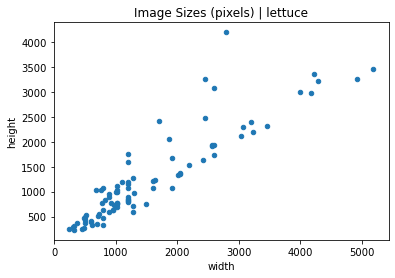

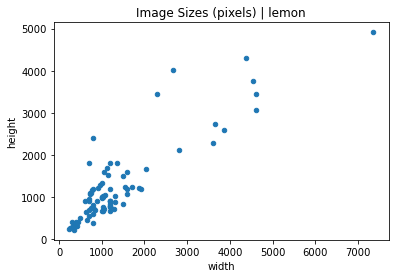

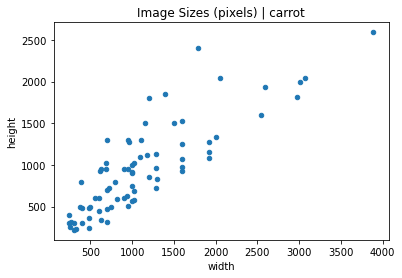

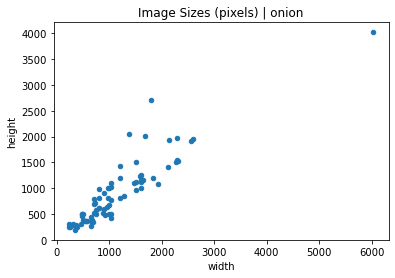

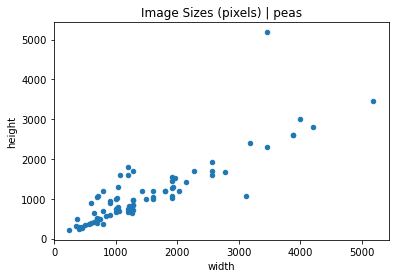

In [16]:
for l,d in labels_dict.items():
    """ Source: https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a
    """
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = db.from_sequence(filelist).map(get_dims)
    with dd.ProgressBar():
        dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height')
    plt.title('Image Sizes (pixels) | {}'.format(l))
    

Image sizes are all over the place. Every single class contains a small amount of very large images as well as an amount of very small images.

# Aux function

In [5]:
def make_model(base_model, input_shape=(299, 299, 3), learning_rate=1e-3):
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    dense1 = keras.layers.Dense(128, activation='relu')(vectors)
    dense2 = keras.layers.Dense(128, activation='relu')(dense1)
    outputs = keras.layers.Dense(36)(dense2)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
        loss = keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    return model

In [9]:
def model_builder(hp, base_model, input_shape=(299, 299, 3)):
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

    dense1 = keras.layers.Dense(units=hp_units, activation='relu')(vectors)
    dense2 = keras.layers.Dense(128, activation='relu')(dense1)
    outputs = keras.layers.Dense(36)(dense2)

    model = keras.Model(inputs, outputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss = keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    return model

# Model Training

Because of the limited dataset, we will make use of Transfer Learning to speed up model training. We will test different convolutional architectures and use their vetor feature representations to train new dense layers on top.

The chosen 3 architectures are:

* Xception: the most popular architecture for image classification for Keras.
* MobileNet v2: a very compact network for lower capacity devices.
* NasNetLarge: a very large network to see how its performance compares against the other 2.

The `Keras Tuner` is a handy library for hyperparameter search. We will use it to define our models and the hyperparameters we'd like to tune.

We will also use `TensorBoard` for visualizing the training.

## Xception

### Datasets

In [15]:
train_gen_xc = ImageDataGenerator(
    preprocessing_function=xc.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds_xc = train_gen_xc.flow_from_dataframe(
    dataframe= train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

val_gen_xc = ImageDataGenerator(
    preprocessing_function=xc.preprocess_input
)

val_ds_xc = val_gen_xc.flow_from_dataframe(
    dataframe= val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0
)

full_train_gen_xc = ImageDataGenerator(
    preprocessing_function=xc.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

full_train_ds_xc = full_train_gen_xc.flow_from_dataframe(
        dataframe= full_train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

test_gen_xc = ImageDataGenerator(
    preprocessing_function=xc.preprocess_input
)

test_ds_xc = test_gen_xc.flow_from_dataframe(
    dataframe= test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0
)

Found 3193 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 3527 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


### Model definition and hyperparameter search

In [5]:
def model_builder_xc(hp):
    base_model = xc.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    x = vectors

    for i in range(hp.Int('dense_layers', 1, 4, default=2)):
        hp_units = hp.Int('units_'+str(i), min_value=32, max_value=256, step=32)
        x = keras.layers.Dense(units=hp_units, activation='relu')(x)

    outputs = keras.layers.Dense(36)(x)

    model = keras.Model(inputs, outputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss = keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    return model

In [7]:
tuner_xc = kt.Hyperband(model_builder_xc,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='xception_models',
                     project_name='xception')

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Change the TensorBoard folder if needed
tensorboard_logs = keras.callbacks.TensorBoard('/tmp/tb_xc_tuning')


2021-12-10 23:05:17.299417: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-10 23:05:17.299435: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-10 23:05:17.390026: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-10 23:05:17.390231: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


> Tensorboard

Due to my setup, I run TensorBoard on a separate terminal:

`tensorboard --logdir /tnp/tb_xc_tuning --bind_all`

Then I open the TensorBoard dashboard on a web browser:

`ml-machine:6006`

However, the following block has been provided to run TensorBoard inline the notebook if needed.

In [ ]:
''' Run this block if you'd like to run TensorBoard in the notebook
'''

# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_xc_tuning

In [8]:
tuner_xc.search(
    train_ds_xc,
    validation_data = val_ds_xc,
    epochs = 50,
    callbacks = [stop_early, tensorboard_logs]
)

Trial 30 Complete [00h 23m 57s]
val_accuracy: 0.9281437397003174

Best val_accuracy So Far: 0.946107804775238
Total elapsed time: 04h 50m 01s
INFO:tensorflow:Oracle triggered exit


In [9]:
tuner_xc.search_space_summary()

Search space summary
Default search space size: 6
dense_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}


In [10]:
tuner_xc.results_summary()

Results summary
Results in xception_models/xception
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dense_layers: 1
units_0: 256
units_1: 256
learning_rate: 0.001
units_2: 224
units_3: 160
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 931b391ba24489d5d8c5a59df8429430
Score: 0.946107804775238
Trial summary
Hyperparameters:
dense_layers: 3
units_0: 192
units_1: 128
learning_rate: 0.001
units_2: 64
units_3: 192
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9281437397003174
Trial summary
Hyperparameters:
dense_layers: 3
units_0: 64
units_1: 96
learning_rate: 0.001
units_2: 224
units_3: 256
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9281437397003174
Trial summary
Hyperparameters:
dense_layers: 2
units_0: 160
units_1: 96
learning_rate: 0.01
units_2: 192
units_3: 32
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tune

In [13]:
best_model_xc = tuner_xc.get_best_models(1)[0]
best_model_xc.evaluate(test_ds_xc)

11/11 [==============================] - 14s 1s/step - loss: 0.1951 - accuracy: 0.9461


[0.195148766040802, 0.946107804775238]

In [14]:
best_model_xc.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 36)                9252      
Total params: 21,395,276
Trainable params: 533,796
Non-trainable params: 20,861,480
_________________________________________________________________


Architecture for Xception's best model:


        Model: "model"
        _________________________________________________________________
        Layer (type)                 Output Shape              Param #   
        =================================================================
        input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
        _________________________________________________________________
        xception (Functional)        (None, 10, 10, 2048)      20861480  
        _________________________________________________________________
        global_average_pooling2d (Gl (None, 2048)              0         
        _________________________________________________________________
        dense (Dense)                (None, 256)               524544    
        _________________________________________________________________
        dense_1 (Dense)              (None, 36)                9252      
        =================================================================
        Total params: 21,395,276
        Trainable params: 533,796
        Non-trainable params: 20,861,480
        _________________________________________________________________

### Final model training

We use the results of our hyperparameter search and train a final model using our combined train+val datasets

In [16]:

def make_xception_model():
    base_model = xc.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    x = keras.layers.Dense(256, activation='relu')(vectors)
    #x = keras.layers.Dense(224, activation='relu')(x)
    outputs = keras.layers.Dense(36)(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=0.001),
        loss = keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    return model


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    #'xception_final/xception_{epoch:02d}_{val_accuracy:.3f}.h5',
    'xception_final.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

tensorboard_logs = keras.callbacks.TensorBoard('/tmp/tb_xc_final')

> Tensorboard

Due to my setup, I run TensorBoard on a separate terminal:

`tensorboard --logdir /tnp/tb_xc_final --bind_all`

Then I open the TensorBoard dashboard on a web browser:

`ml-machine:6006`

However, the following block has been provided to run TensorBoard inline the notebook if needed.

In [ ]:
''' Run this block if you'd like to run TensorBoard in the notebook
    Otherwise, run the last line without the % character on a terminal and use a web browser
    If running TensorBoard locally, simply browse to localhost:6006
'''

# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_xc_final

In [17]:
final_model_xc = make_xception_model()

history = final_model_xc.fit(
    full_train_ds_xc,
    epochs=10,
    validation_data=val_ds_xc,
    callbacks=[checkpoint, tensorboard_logs]
)

2021-12-11 08:31:26.806136: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-11 08:31:26.806201: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-11 08:31:26.954366: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-11 08:31:26.954616: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/home/ziri/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/10
  1/111 [..............................] - ETA: 5:21 - loss: 3.6288 - accuracy: 0.0312

2021-12-11 08:31:32.464907: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-11 08:31:32.464929: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/111 [..............................] - ETA: 2:05 - loss: 3.6277 - accuracy: 0.0312

2021-12-11 08:31:33.669237: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-11 08:31:33.669711: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-12-11 08:31:33.720459: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 285 callback api events and 283 activity events. 
2021-12-11 08:31:33.727495: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-11 08:31:33.732756: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tb_xc_final/train/plugins/profile/2021_12_11_08_31_33

2021-12-11 08:31:33.737308: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /tmp/tb_xc_final/train/plugins/profile/2021_12_11_08_31_33/kenya.trace.json.gz
2021-12-11 08:31:33.759443: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory

 72/111 [==================>...........] - ETA: 52s - loss: 1.8686 - accuracy: 0.5252

/home/ziri/anaconda3/envs/tf/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


111/111 [==============================] - 162s 1s/step - loss: 1.5533 - accuracy: 0.5948 - val_loss: 0.3943 - val_accuracy: 0.8743
Epoch 2/10
111/111 [==============================] - 159s 1s/step - loss: 0.7292 - accuracy: 0.7803 - val_loss: 0.2842 - val_accuracy: 0.9162
Epoch 3/10
111/111 [==============================] - 160s 1s/step - loss: 0.5765 - accuracy: 0.8222 - val_loss: 0.1933 - val_accuracy: 0.9461
Epoch 4/10
111/111 [==============================] - 160s 1s/step - loss: 0.4822 - accuracy: 0.8415 - val_loss: 0.1620 - val_accuracy: 0.9581
Epoch 5/10
111/111 [==============================] - 160s 1s/step - loss: 0.4091 - accuracy: 0.8707 - val_loss: 0.1393 - val_accuracy: 0.9641
Epoch 6/10
111/111 [==============================] - 160s 1s/step - loss: 0.3666 - accuracy: 0.8806 - val_loss: 0.1359 - val_accuracy: 0.9491
Epoch 7/10
111/111 [==============================] - 160s 1s/step - loss: 0.3062 - accuracy: 0.8945 - val_loss: 0.1266 - val_accuracy: 0.9581
Epoch 8/10

In [ ]:
''' You can run Tensorboard inside Jupyter Network by running this block
'''

%load_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

In [20]:
''' Remove old TensorBoard logs with this block
'''
!rm -rf /tmp/tb_logs

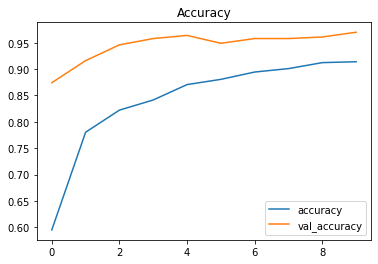

In [18]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

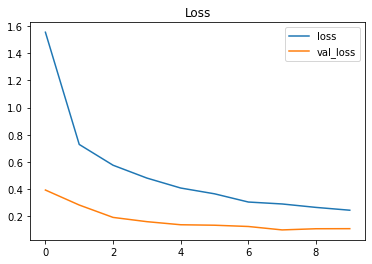

In [19]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

## MobileNet V2

### Datasets

In [32]:
train_gen_mn = ImageDataGenerator(
    preprocessing_function=mn.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds_mn = train_gen_mn.flow_from_dataframe(
    dataframe= train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

val_gen_mn = ImageDataGenerator(
    preprocessing_function=mn.preprocess_input,
)

val_ds_mn = val_gen_mn.flow_from_dataframe(
    dataframe= val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0
)

full_train_gen_mn = ImageDataGenerator(
    preprocessing_function=mn.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

full_train_ds_mn = full_train_gen_mn.flow_from_dataframe(
        dataframe= full_train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

test_gen_mn = ImageDataGenerator(
    preprocessing_function=mn.preprocess_input
)

test_ds_mn = test_gen_mn.flow_from_dataframe(
    dataframe= test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0
)

Found 3193 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 3527 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


### Model definition and hyperparameter search

In [33]:
def model_builder_mn(hp):
    base_model = mn.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    x = vectors

    for i in range(hp.Int('dense_layers', 1, 4, default=2)):
        hp_units = hp.Int('units_'+str(i), min_value=32, max_value=256, step=32)
        x = keras.layers.Dense(units=hp_units, activation='relu')(x)

    outputs = keras.layers.Dense(36)(x)

    model = keras.Model(inputs, outputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss = keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    return model

In [34]:
tuner_mn = kt.Hyperband(model_builder_mn,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='mobilenet_models',
                     project_name='mobilenet')

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Change the TensorBoard folder if needed
tensorboard_logs = keras.callbacks.TensorBoard('/tmp/tb_mn_tuning')

2021-12-11 09:35:50.048979: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-11 09:35:50.049002: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-11 09:35:50.167995: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-11 09:35:50.168121: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


> Tensorboard

In [ ]:
''' Run this block if you'd like to run TensorBoard in the notebook
    Otherwise, run the last line without the % character on a terminal and use a web browser
    If running TensorBoard locally, simply browse to localhost:6006
'''

# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_mn_tuning

In [35]:
tuner_mn.search(
    train_ds_mn,
    validation_data = val_ds_mn,
    epochs = 50,
    callbacks = [stop_early, tensorboard_logs]
)

Trial 30 Complete [00h 20m 38s]
val_accuracy: 0.8293412923812866

Best val_accuracy So Far: 0.9580838084220886
Total elapsed time: 04h 09m 31s
INFO:tensorflow:Oracle triggered exit


In [36]:
tuner_mn.search_space_summary()

Search space summary
Default search space size: 6
dense_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}


In [37]:
tuner_mn.results_summary()

Results summary
Results in mobilenet_models/mobilenet
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dense_layers: 2
units_0: 128
units_1: 96
learning_rate: 0.001
units_2: 224
units_3: 160
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9580838084220886
Trial summary
Hyperparameters:
dense_layers: 1
units_0: 224
units_1: 256
learning_rate: 0.001
units_2: 192
units_3: 96
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.955089807510376
Trial summary
Hyperparameters:
dense_layers: 2
units_0: 192
units_1: 192
learning_rate: 0.001
units_2: 224
units_3: 32
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: e818564f6ba8217cd284f370da13c265
Score: 0.93113774061203
Trial summary
Hyperparameters:
dense_layers: 4
units_0: 224
units_1: 256
learning_rate: 0.0001
units_2: 64
units_3: 224
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
t

In [38]:
best_model_mn = tuner_mn.get_best_models(1)[0]
best_model_mn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 96)                12384     
_________________________________________________________________
dense_2 (Dense)              (None, 36)                3492      
Total params: 2,437,828
Trainable params: 179,844
Non-trainable params: 2,257,984
_____________________________________________

In [56]:
best_model_mn.evaluate(test_ds_mn)

11/11 [==============================] - 14s 1s/step - loss: 0.1667 - accuracy: 0.9581


[0.16671477258205414, 0.9580838084220886]

### Final model training

In [42]:
def make_mobilenet_model():
    base_model = mn.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    x = keras.layers.Dense(128, activation='relu')(vectors)
    x = keras.layers.Dense(96, activation='relu')(x)
    outputs = keras.layers.Dense(36)(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=0.001),
        loss = keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    return model

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'mobilenet_final.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

tensorboard_logs = keras.callbacks.TensorBoard('/tmp/tb_mn_final')

> Tensorboard

In [ ]:
''' Run this block if you'd like to run TensorBoard in the notebook
    Otherwise, run the last line without the % character on a terminal and use a web browser
    If running TensorBoard locally, simply browse to localhost:6006
'''

# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_mn_final

In [43]:
final_model_mn = make_mobilenet_model()

history = final_model_mn.fit(
    full_train_ds_mn,
    epochs=10,
    validation_data=val_ds_mn,
    callbacks=[checkpoint, tensorboard_logs]
)

2021-12-11 13:49:49.651109: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-11 13:49:49.651161: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-11 13:49:49.808153: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-11 13:49:49.808405: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/10
  1/111 [..............................] - ETA: 4:55 - loss: 3.5474 - accuracy: 0.0938

2021-12-11 13:49:54.915542: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-11 13:49:54.915568: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/111 [..............................] - ETA: 1:47 - loss: 3.6502 - accuracy: 0.0469

2021-12-11 13:49:55.961406: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-11 13:49:55.962338: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-12-11 13:49:56.012502: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 298 callback api events and 296 activity events. 
2021-12-11 13:49:56.019770: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-11 13:49:56.028004: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tb_mn_final/train/plugins/profile/2021_12_11_13_49_56

2021-12-11 13:49:56.033615: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /tmp/tb_mn_final/train/plugins/profile/2021_12_11_13_49_56/kenya.trace.json.gz
2021-12-11 13:49:56.060910: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory

103/111 [==========================>...] - ETA: 9s - loss: 2.0926 - accuracy: 0.4482 

/home/ziri/anaconda3/envs/tf/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


111/111 [==============================] - 143s 1s/step - loss: 2.0175 - accuracy: 0.4673 - val_loss: 0.5013 - val_accuracy: 0.8683
Epoch 2/10
111/111 [==============================] - 138s 1s/step - loss: 0.9073 - accuracy: 0.7295 - val_loss: 0.2925 - val_accuracy: 0.8982
Epoch 3/10
111/111 [==============================] - 139s 1s/step - loss: 0.6966 - accuracy: 0.7930 - val_loss: 0.2257 - val_accuracy: 0.9311
Epoch 4/10
111/111 [==============================] - 139s 1s/step - loss: 0.5744 - accuracy: 0.8160 - val_loss: 0.1604 - val_accuracy: 0.9521
Epoch 5/10
111/111 [==============================] - 138s 1s/step - loss: 0.4973 - accuracy: 0.8421 - val_loss: 0.1562 - val_accuracy: 0.9551
Epoch 6/10
111/111 [==============================] - 138s 1s/step - loss: 0.4259 - accuracy: 0.8585 - val_loss: 0.1630 - val_accuracy: 0.9371
Epoch 7/10
111/111 [==============================] - 139s 1s/step - loss: 0.3754 - accuracy: 0.8741 - val_loss: 0.1193 - val_accuracy: 0.9641
Epoch 8/10

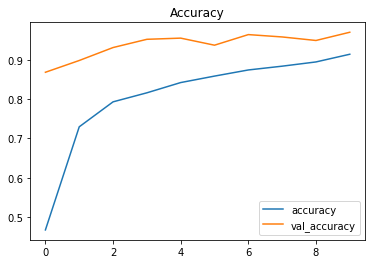

In [44]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

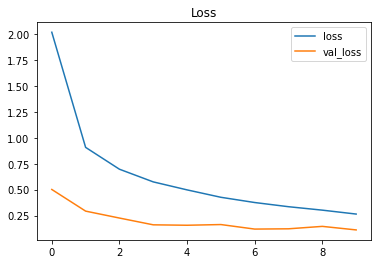

In [45]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# NASNetLarge

In [48]:
train_gen_nas = ImageDataGenerator(
    preprocessing_function=nas.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds_nas = train_gen_nas.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(331, 331),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

val_gen_nas = ImageDataGenerator(
    preprocessing_function=nas.preprocess_input
)

val_ds_nas = val_gen_nas.flow_from_dataframe(
    dataframe= val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(331, 331),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0
)

full_train_gen_nas = ImageDataGenerator(
    preprocessing_function=nas.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

full_train_ds_nas = train_gen_nas.flow_from_dataframe(
    dataframe=full_train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(331, 331),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

test_gen_nas = ImageDataGenerator(
    preprocessing_function=nas.preprocess_input
)

test_ds_nas = test_gen_nas.flow_from_dataframe(
    dataframe= test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0
)

Found 3193 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 3527 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [49]:
def model_builder_nas(hp):
    base_model = nas.NASNetLarge(
        weights='imagenet',
        include_top=False,
        # When loading imagenet weights, we're forced to use this shape
        input_shape=(331, 331, 3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(331, 331, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    x = vectors

    for i in range(hp.Int('dense_layers', 1, 4, default=2)):
        hp_units = hp.Int('units_'+str(i), min_value=32, max_value=256, step=32)
        x = keras.layers.Dense(units=hp_units, activation='relu')(x)

    outputs = keras.layers.Dense(36)(x)

    model = keras.Model(inputs, outputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss = keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    return model

In [50]:
tuner_nas = kt.Hyperband(model_builder_nas,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='nasnet_models',
                     project_name='nasnet')

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Change the TensorBoard folder if needed
tensorboard_logs = keras.callbacks.TensorBoard('/tmp/tb_nas_tuning')

2021-12-11 14:16:03.902175: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-11 14:16:03.902195: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-11 14:16:04.001025: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-11 14:16:04.001177: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


> Tensorboard

In [ ]:
''' Run this block if you'd like to run TensorBoard in the notebook
    Otherwise, run the last line without the % character on a terminal and use a web browser
    If running TensorBoard locally, simply browse to localhost:6006
'''

# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_nas_tuning

In [51]:
tuner_nas.search(
    train_ds_nas,
    validation_data = val_ds_nas,
    epochs = 50,
    callbacks = [stop_early, tensorboard_logs]
)

Trial 30 Complete [00h 26m 19s]
val_accuracy: 0.8832335472106934

Best val_accuracy So Far: 0.9041916131973267
Total elapsed time: 05h 24m 09s
INFO:tensorflow:Oracle triggered exit


In [53]:
tuner_nas.search_space_summary()

Search space summary
Default search space size: 6
dense_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}


In [54]:
tuner_nas.results_summary()

Results summary
Results in nasnet_models/nasnet
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dense_layers: 2
units_0: 128
units_1: 96
learning_rate: 0.001
units_2: 160
units_3: 64
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 4bbbbb5f53a77743cccc99d5d81e4dc2
Score: 0.9041916131973267
Trial summary
Hyperparameters:
dense_layers: 2
units_0: 160
units_1: 224
learning_rate: 0.001
units_2: 192
units_3: 96
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: ab25713bc85778c88cf3090bfd493dab
Score: 0.901197612285614
Trial summary
Hyperparameters:
dense_layers: 2
units_0: 160
units_1: 224
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 1d604a099f0f3d9303b734b7c9411b4e
Score: 0.8952096104621887
Trial summary
Hyperparameters:
dense_layers: 3
units_0: 160
units_1: 224
learning_rate: 0.001
units_2: 224
uni

In [55]:
best_model_nas = tuner_nas.get_best_models(1)[0]
best_model_nas.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               516224    
_________________________________________________________________
dense_1 (Dense)              (None, 96)                12384     
_________________________________________________________________
dense_2 (Dense)              (None, 36)                3492      
Total params: 85,448,918
Trainable params: 532,100
Non-trainable params: 84,916,818
___________________________________________

In [57]:
best_model_nas.evaluate(test_ds_nas)

11/11 [==============================] - 22s 1s/step - loss: 0.2661 - accuracy: 0.8982


[0.26611003279685974, 0.8982036113739014]

### Final model training

In [58]:
def make_nasnet_model():
    base_model = nas.NASNetLarge(
        weights='imagenet',
        include_top=False,
        # When loading imagenet weights, we're forced to use this shape
        input_shape=(331, 331, 3)
    )
    base_model.trainable = False
    
    inputs = keras.Input(shape=(331, 331, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    x = keras.layers.Dense(128, activation='relu')(vectors)
    x = keras.layers.Dense(96, activation='relu')(x)
    outputs = keras.layers.Dense(36)(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=0.001),
        loss = keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    return model


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'nasnet_final.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

tensorboard_logs = keras.callbacks.TensorBoard('/tmp/tb_nas_final')

> Tensorboard

In [ ]:
''' Run this block if you'd like to run TensorBoard in the notebook
    Otherwise, run the last line without the % character on a terminal and use a web browser
    If running TensorBoard locally, simply browse to localhost:6006
'''

# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_nas_final

In [59]:
final_model_nas = make_nasnet_model()

history = final_model_nas.fit(
    full_train_ds_nas,
    epochs=10,
    validation_data=val_ds_nas,
    callbacks=[checkpoint, tensorboard_logs]
)

2021-12-11 19:58:06.150826: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-11 19:58:06.150847: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-11 19:58:06.270558: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-11 19:58:06.270714: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/home/ziri/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/10
  1/111 [..............................] - ETA: 21:34 - loss: 3.5615 - accuracy: 0.0625

2021-12-11 19:58:26.360461: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-11 19:58:26.360490: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/111 [..............................] - ETA: 2:08 - loss: 3.5322 - accuracy: 0.0625 

2021-12-11 19:58:27.862389: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-11 19:58:27.869054: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-12-11 19:58:27.949351: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1750 callback api events and 1755 activity events. 
2021-12-11 19:58:28.000749: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-11 19:58:28.045130: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tb_nas_final/train/plugins/profile/2021_12_11_19_58_28

2021-12-11 19:58:28.074059: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /tmp/tb_nas_final/train/plugins/profile/2021_12_11_19_58_28/kenya.trace.json.gz
2021-12-11 19:58:28.160287: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating direc

 49/111 [============>.................] - ETA: 1:30 - loss: 2.2697 - accuracy: 0.4213

/home/ziri/anaconda3/envs/tf/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


111/111 [==============================] - 192s 2s/step - loss: 1.6453 - accuracy: 0.5605 - val_loss: 0.5513 - val_accuracy: 0.7964
Epoch 2/10
111/111 [==============================] - 173s 2s/step - loss: 0.7789 - accuracy: 0.7502 - val_loss: 0.3463 - val_accuracy: 0.8892
Epoch 3/10
111/111 [==============================] - 173s 2s/step - loss: 0.6050 - accuracy: 0.7944 - val_loss: 0.2667 - val_accuracy: 0.9012
Epoch 4/10
111/111 [==============================] - 174s 2s/step - loss: 0.4870 - accuracy: 0.8316 - val_loss: 0.3171 - val_accuracy: 0.8832
Epoch 5/10
111/111 [==============================] - 172s 2s/step - loss: 0.4257 - accuracy: 0.8472 - val_loss: 0.2549 - val_accuracy: 0.8982
Epoch 6/10
111/111 [==============================] - 173s 2s/step - loss: 0.3838 - accuracy: 0.8594 - val_loss: 0.2045 - val_accuracy: 0.9192
Epoch 7/10
111/111 [==============================] - 173s 2s/step - loss: 0.3385 - accuracy: 0.8772 - val_loss: 0.1957 - val_accuracy: 0.9132
Epoch 8/10

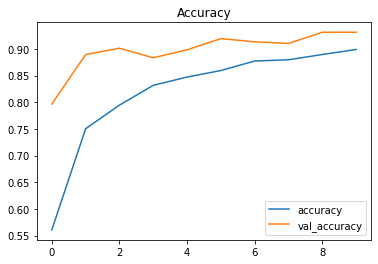

In [60]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

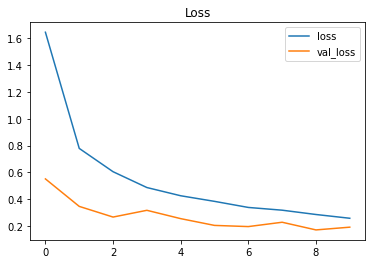

In [61]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# Comparing the models

With all of the 3 models trained with the full dataset and tuned, let's evaluate them on the test dataset.

In [20]:
final_model_xc = keras.models.load_model("xception_final.h5")
final_model_xc.evaluate(test_ds_xc)

11/11 [==============================] - 14s 1s/step - loss: 0.1105 - accuracy: 0.9701


[0.11051276326179504, 0.970059871673584]

In [46]:
final_model_mn = keras.models.load_model("mobilenet_final.h5")
final_model_mn.evaluate(test_ds_mn)

11/11 [==============================] - 13s 1s/step - loss: 0.1113 - accuracy: 0.9701


[0.11125572770833969, 0.970059871673584]

In [62]:
final_model_nas = keras.models.load_model("nasnet_final.h5")
final_model_nas.evaluate(test_ds_nas)

11/11 [==============================] - 17s 1s/step - loss: 0.1476 - accuracy: 0.9341


[0.14757438004016876, 0.9341317415237427]

Both `Xception` and `mobilenet` performed very well. Despite its bigger size, `nasnet` did not perform as well.

`Xception` has slightly less loss than `mobilenet`, but let's compare the model sizes.

In [65]:
filesize_xc = os.path.getsize('xception_final.h5')
filesize_mn = os.path.getsize('mobilenet_final.h5')
filesize_nas = os.path.getsize('nasnet_final.h5')
print(f'Xception: {filesize_xc / (1024**2)} MB')
print(f'Mobilenet: {filesize_mn / (1024**2)} MB')
print(f'Nasnet: {filesize_nas / (1024**2)} MB')

Xception: 85.95491027832031 MB
Mobilenet: 10.983741760253906 MB
Nasnet: 331.67525482177734 MB


`Mobilenet` is almost an order of magnitude smaller than `Xception`, so we will use it for deployment.

Finally, let's see how they all 3 handle predicting the class of random downloaded images outside of the database.

In [74]:
path1 = 'data/eggplant.jpeg'
path2 = 'data/beetroot.jpg'
path3 = 'data/capsicum.jpg'
img1 = load_img(path1, target_size=(299, 299))
img2 = load_img(path2, target_size=(299, 299))
img3 = load_img(path3, target_size=(299, 299))
x1 = np.array(img1)
x2 = np.array(img2)
x3 = np.array(img3)
X = np.array([x1, x2, x3])
X = xc.preprocess_input(X)
pred = final_model_xc.predict(X)
labels = train_ds_xc.class_indices.keys()
res = []
for i in range(len(pred)):
    pred_dict = dict(zip(labels, pred[i]))
    res.append(max(pred_dict, key=pred_dict.get))
res

['eggplant', 'beetroot', 'capsicum']

In [76]:
path1 = 'data/eggplant.jpeg'
path2 = 'data/beetroot.jpg'
path3 = 'data/capsicum.jpg'
img1 = load_img(path1, target_size=(224, 224))
img2 = load_img(path2, target_size=(224, 224))
img3 = load_img(path3, target_size=(224, 224))
x1 = np.array(img1)
x2 = np.array(img2)
x3 = np.array(img3)
X = np.array([x1, x2, x3])
X = mn.preprocess_input(X)
pred = final_model_mn.predict(X)
labels = train_ds_mn.class_indices.keys()
res = []
for i in range(len(pred)):
    pred_dict = dict(zip(labels, pred[i]))
    res.append(max(pred_dict, key=pred_dict.get))
res

['eggplant', 'beetroot', 'capsicum']

In [77]:
path1 = 'data/eggplant.jpeg'
path2 = 'data/beetroot.jpg'
path3 = 'data/capsicum.jpg'
img1 = load_img(path1, target_size=(331, 331))
img2 = load_img(path2, target_size=(331, 331))
img3 = load_img(path3, target_size=(331, 331))
x1 = np.array(img1)
x2 = np.array(img2)
x3 = np.array(img3)
X = np.array([x1, x2, x3])
X = nas.preprocess_input(X)
pred = final_model_nas.predict(X)
labels = train_ds_nas.class_indices.keys()
res = []
for i in range(len(pred)):
    pred_dict = dict(zip(labels, pred[i]))
    res.append(max(pred_dict, key=pred_dict.get))
res

['eggplant', 'watermelon', 'capsicum']

Oops, `Nasnet` made a mistake with the second image...

# Convert model to TFLite

We will now convert the model we've chosen (`Mobilenet`) and convert it to `tflite` for easier deployment.

In [78]:
model = keras.models.load_model('mobilenet_final.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)

model_lite = converter.convert()

2021-12-11 21:47:45.835197: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpwqhymjgi/assets


/home/ziri/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2021-12-11 21:47:54.188680: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-12-11 21:47:54.188742: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-12-11 21:47:54.189829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7365 MB memory:  -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2021-12-11 21:47:54.195971: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_opti

In [79]:
with open('model.tflite', 'wb') as f_out:
    f_out.write(model_lite)

# Implementing image preprocessing

In order to reduce dependencies, we need to know what exacly `mn.preprocess_input()` is doing.

In [83]:
path = 'data/capsicum.jpg'
img = load_img(path, target_size=(224, 224))
x = np.array(img, dtype='float32')
X = np.array([x])
X_preprocess = np.array([x])
X_custom = np.array([x])
X

array([[[[244., 234., 233.],
         [249., 239., 238.],
         [250., 240., 239.],
         ...,
         [ 80., 111.,  43.],
         [113., 143.,  47.],
         [ 56.,  88.,  15.]],

        [[240., 236., 237.],
         [244., 240., 241.],
         [240., 236., 237.],
         ...,
         [131., 165.,  79.],
         [ 94., 120.,  46.],
         [ 87., 118.,  50.]],

        [[243., 244., 249.],
         [244., 245., 250.],
         [243., 244., 249.],
         ...,
         [158., 194.,  94.],
         [ 89., 111.,  62.],
         [ 64.,  94.,  30.]],

        ...,

        [[202., 125.,  95.],
         [200., 109.,  82.],
         [168., 101.,  75.],
         ...,
         [ 56.,  87.,  30.],
         [ 40.,  40.,  30.],
         [ 77., 103.,  55.]],

        [[202., 118.,  84.],
         [192., 111.,  84.],
         [177., 106.,  84.],
         ...,
         [ 43.,  61.,  35.],
         [ 38.,  56.,  30.],
         [ 35.,  53.,  27.]],

        [[197., 113.,  79.],
       

In [85]:
X_preprocess = mn.preprocess_input(X_preprocess)
X_preprocess

array([[[[ 0.9137255 ,  0.8352941 ,  0.827451  ],
         [ 0.9529412 ,  0.8745098 ,  0.8666667 ],
         [ 0.9607843 ,  0.88235295,  0.8745098 ],
         ...,
         [-0.372549  , -0.12941176, -0.6627451 ],
         [-0.11372548,  0.12156868, -0.6313726 ],
         [-0.56078434, -0.3098039 , -0.88235295]],

        [[ 0.88235295,  0.8509804 ,  0.85882354],
         [ 0.9137255 ,  0.88235295,  0.8901961 ],
         [ 0.88235295,  0.8509804 ,  0.85882354],
         ...,
         [ 0.02745104,  0.2941177 , -0.38039213],
         [-0.26274508, -0.05882353, -0.6392157 ],
         [-0.31764704, -0.0745098 , -0.60784316]],

        [[ 0.90588236,  0.9137255 ,  0.9529412 ],
         [ 0.9137255 ,  0.92156863,  0.9607843 ],
         [ 0.90588236,  0.9137255 ,  0.9529412 ],
         ...,
         [ 0.23921573,  0.52156866, -0.26274508],
         [-0.30196077, -0.12941176, -0.5137255 ],
         [-0.4980392 , -0.26274508, -0.7647059 ]],

        ...,

        [[ 0.58431375, -0.01960784, -0

The source code for nm.preprocess_input() is available at:

https://github.com/keras-team/keras/blob/v2.7.0/keras/applications/mobilenet.py#L442-L444

We can see that it calls another function here:

https://github.com/keras-team/keras/blob/2c48a3b38b6b6139be2da501982fd2f61d7d48fe/keras/applications/imagenet_utils.py#L101

And this function calls another function here:

https://github.com/keras-team/keras/blob/2c48a3b38b6b6139be2da501982fd2f61d7d48fe/keras/applications/imagenet_utils.py#L168

Since the `tf` parameter is passed along from the first function, it seems that the 3 important lines of code are 192, 193 and 194.

Let's test them.

In [84]:
X_custom /= 127.5
X_custom -= 1.
X_custom

array([[[[ 0.9137255 ,  0.8352941 ,  0.827451  ],
         [ 0.9529412 ,  0.8745098 ,  0.8666667 ],
         [ 0.9607843 ,  0.88235295,  0.8745098 ],
         ...,
         [-0.372549  , -0.12941176, -0.6627451 ],
         [-0.11372548,  0.12156868, -0.6313726 ],
         [-0.56078434, -0.3098039 , -0.88235295]],

        [[ 0.88235295,  0.8509804 ,  0.85882354],
         [ 0.9137255 ,  0.88235295,  0.8901961 ],
         [ 0.88235295,  0.8509804 ,  0.85882354],
         ...,
         [ 0.02745104,  0.2941177 , -0.38039213],
         [-0.26274508, -0.05882353, -0.6392157 ],
         [-0.31764704, -0.0745098 , -0.60784316]],

        [[ 0.90588236,  0.9137255 ,  0.9529412 ],
         [ 0.9137255 ,  0.92156863,  0.9607843 ],
         [ 0.90588236,  0.9137255 ,  0.9529412 ],
         ...,
         [ 0.23921573,  0.52156866, -0.26274508],
         [-0.30196077, -0.12941176, -0.5137255 ],
         [-0.4980392 , -0.26274508, -0.7647059 ]],

        ...,

        [[ 0.58431375, -0.01960784, -0

We can see that the preprocess input for `Mobilenet` consists of 2 simple arithmetic operations which we can implement easily for deployment.